In [1]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time

In [3]:
from ta import *

In [4]:
df = pd.read_csv('dataset/goog-train.csv')
df.head()

,High,Low,Open,Close,Volume,Adj Close
0,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
1,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
3,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
4,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680


In [5]:
def calculate_indicators(df):
    short_window = int(0.025 * len(df))
    long_window = int(0.05 * len(df))

    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0

    signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                                > signals['long_ma'][short_window:], 1.0, 0.0)   
    signals['positions'] = signals['signal'].diff()

    #signals
    df['position']=signals['positions']
    
    ######################rsi
    df['rsi_ind']=rsi(df['Close'], n=20)
    
    # Add bollinger band high indicator filling NaN values
    df['bb_high_indicator'] = bollinger_hband_indicator(df["Close"], n=20, ndev=1, fillna=True)

    # Add bollinger band low indicator filling NaN values
    df['bb_low_indicator'] = bollinger_lband_indicator(df["Close"], n=20, ndev=1, fillna=True)
    
    
    return df

In [6]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

In [7]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [8]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual, trends):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(trends) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= trends[t] and  rsi_n[t]<=30 and trends[t]>bbl[t]:
                inventory.append(trends[t])
                initial_money -= trends[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, trends[t], initial_money))
            
            elif action == 2 and len(inventory) and (rsi_n[t]>=70 or trends[t]>bbh[t] ) and trends[t]>bbl[t] :
                bought_price = inventory.pop(0)
                initial_money += trends[t]
                states_sell.append(t)
                try:
                    invest = ((trends[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, trends[t], invest, initial_money)
                )
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t] :
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) :
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
    
    def evolve(self, generations=20, checkpoint= 5):
        start=time.time()
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        end=time.time()
        print("Time :")
        print(end-start)
        return fittest_individual

In [9]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)
df_new=calculate_indicators(df)
position=df_new['position']
bbh=df_new['bb_high_indicator']
bbl=df_new['bb_low_indicator']
rsi_n=df_new['rsi_ind']

In [10]:
fittest_nets = neural_evolve.evolve(50)

epoch 5, fittest individual 72 with accuracy 53.610386
epoch 10, fittest individual 0 with accuracy 53.610386
epoch 15, fittest individual 75 with accuracy 68.261858
epoch 20, fittest individual 0 with accuracy 68.261858
epoch 25, fittest individual 0 with accuracy 68.261858
epoch 30, fittest individual 0 with accuracy 68.261858
epoch 35, fittest individual 0 with accuracy 82.862946
epoch 40, fittest individual 0 with accuracy 82.862946
epoch 45, fittest individual 0 with accuracy 86.453629
epoch 50, fittest individual 74 with accuracy 87.216443
Time :
232.12096500396729


In [12]:
time.time()

1570314789.924711

In [13]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets,close)

day 161: buy 1 unit at price 589.609985, total balance 9410.390015
day 162, sell 1 unit at price 582.059998, investment -1.280505 %, total balance 9992.450012,
day 332: buy 1 unit at price 691.020020, total balance 9301.429993
day 333: buy 1 unit at price 693.010010, total balance 8608.419983
day 334, sell 1 unit at price 698.210022, investment 1.040491 %, total balance 9306.630005,
day 335, sell 1 unit at price 692.359985, investment -0.093797 %, total balance 9998.989990,
day 367: buy 1 unit at price 691.719971, total balance 9307.270020
day 372: buy 1 unit at price 675.219971, total balance 8632.050049
day 373: buy 1 unit at price 668.260010, total balance 7963.790039
day 374, sell 1 unit at price 680.039978, investment -1.688544 %, total balance 8643.830017,
day 375, sell 1 unit at price 684.109985, investment 1.316610 %, total balance 9327.940002,
day 385, sell 1 unit at price 720.950012, investment 7.884656 %, total balance 10048.890015,


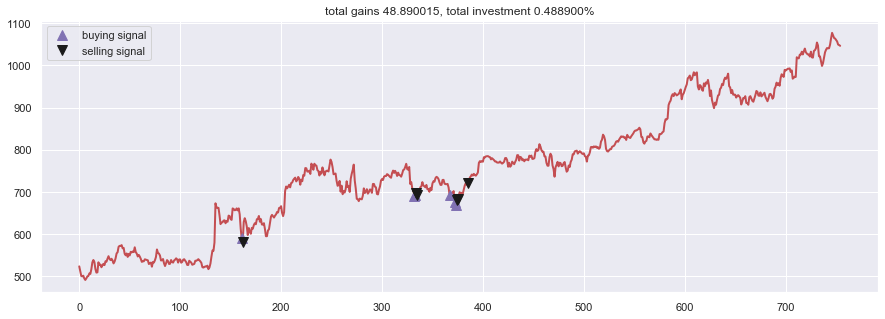

In [14]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [15]:
df2 = pd.read_csv('dataset/goog-test.csv')
close2 = df2.Close.values.tolist()
df_new2=calculate_indicators(df2)
position=df_new2['position']
bbh=df_new2['bb_high_indicator']
bbl=df_new2['bb_low_indicator']
rsi=df_new2['rsi_ind']

In [16]:
states_buy2, states_sell2, total_gains2, invest2 = neural_evolve.buy(fittest_nets,close2)

day 161: buy 1 unit at price 1207.329956, total balance 8792.670044
day 162, sell 1 unit at price 1205.380005, investment -0.161509 %, total balance 9998.050049,


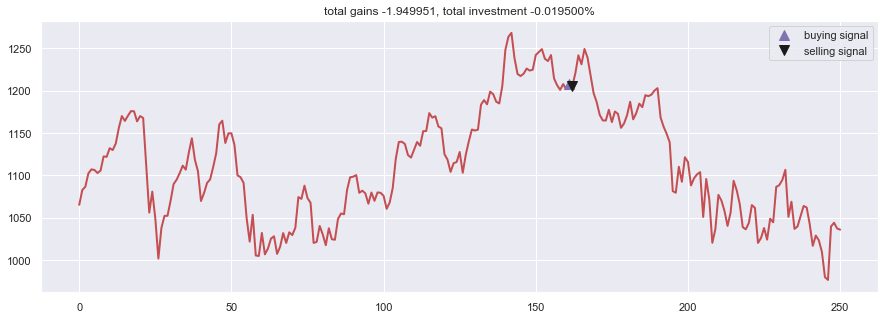

In [17]:
fig = plt.figure(figsize = (15,5))
plt.plot(close2, color='r', lw=2.)
plt.plot(close2, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy2)
plt.plot(close2, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell2)
plt.title('total gains %f, total investment %f%%'%(total_gains2, invest2))
plt.legend()
plt.show()

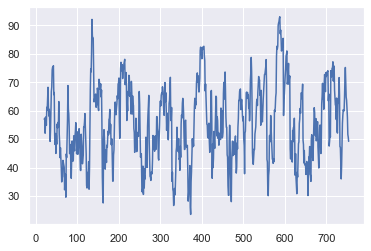

In [18]:
plt.plot(rsi_n)